In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
# import pymc3 as pm
import seaborn as sns

# import arviz as az

## If this isn't working, see the Week 5 notebook
# from causalgraphicalmodels import CausalGraphicalModel 

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# Direct random sampling algorithm
Suppose we want to sample a random time $\tau$ from a distribution given by a probability density function $p(t)$.

We can define the cumulative distribution in the usual way with 
$$ \text{Prob}(\tau < t) = P(t) = \int_0^t p(s) ds. $$

Assume that we have $P(t)$. Consider the random variable
$$ U = P(\tau).$$
One can show that $U$ is always a uniform random variable regardless of the cumulative distribution $P$. We have
\begin{align*}
  U &\sim \text{Uniform}(0, 1) \\
  \tau &= P^{-1}(U)
\end{align*}


## Proof:
We want to show that $U$ is uniformly distributed between zero and one. 
In other words, we want to show that the density function for $U$ is $f(u) = 1$.

Why do we want to show this? If we know that $U$ is uniformly distributed, we can use a programming language like Python to generate uniform random variables (this function is commonly available in many languages) and convert them to *any* type of random variable $\tau$ by inverting the cumulative distribution function, that is, we simply set
$$\tau = P^{-1}(U).$$
We don't have to develop a different algorithm to sample from every possible type of random variable. We just have to have a way of generating one kind of random variable, uniform, and it can be converted to any other kind of random variable so long as we know the distribution function. (We can even estimate the distribution function from data!)

The fact that $U \in (0, 1)$ follows from the fact that the range of *any* distribution function is $(0, 1)$. Furthermore, $P(t)$ is an increasing function with $P(0) = 0$ and $\lim_{t\to\infty}P(t) = 1$. Hence, $P(t)$ is a bijective function and the inverse function $P^{-1}(u)$ exists for all $u\in(0, 1)$ (**even if we cannot always compute the inverse function explicitly**).


For the next step, recall that the cumulative distribution function for $\tau$ is
$$P(t) = \text{Prob}[\tau < t] = \int_0^t p(t')dt'.$$
We begin by noting that since $P(t)$ is an increasing function, its inverse function $P^{-1}(u)$ is also an increasing function.
It follows that if $P(\tau) < u$ then $\tau < P^{-1}(u)$.
The cumulative distribution function for $U = P(\tau)$ is
$$
F(u) = \text{Prob}[U < u] = \text{Prob}[P(\tau) < u] = \text{Prob}[\tau < P^{-1}(u)] = P(P^{-1}(u)) = u.
$$
It follows that the density function for $U$ is $f(u) = F'(u) = 1$.

## Example: generating exponential random times
Suppose we want to sample 
$$ \tau \sim \text{Exponential}(\lambda).$$
(**This lies at the heart of the so called Gillespie algorithm for sampling continuous time Markov chains.**)
Recall that the density function is $p(t) = \lambda e^{-\lambda t}$ and the cumulative distribution function is
$$ P(t) = 1 - e^{-\lambda t}. $$

We want to solve the following for $\tau$
$$ U = P(\tau) = 1 - e^{-\lambda \tau}$$
Manipulating the above equation yields
$$ e^{-\lambda \tau} = 1 - U,$$
and
$$ -\lambda \tau = \log(1 - U),$$
Finally,
$$ \tau = -\frac{1}{\lambda} \log(1 - U) $$
Note that by symmetry, if $U \sim \text{Uniform}(0, 1)$ then we also have that $1-U \sim \text{Uniform}(0, 1)$, so we could write the above as 
$$ \tau = -\frac{1}{\lambda} \log(U). $$

In [21]:
N = 1000 # number of samples to generate
lam = 0.5 # rate parameter in the exponential distribution

u = rand(N)

tau = -log(1-u)/lam

print(tau.mean(), 1/lam)

2.0120142540011647 2.0


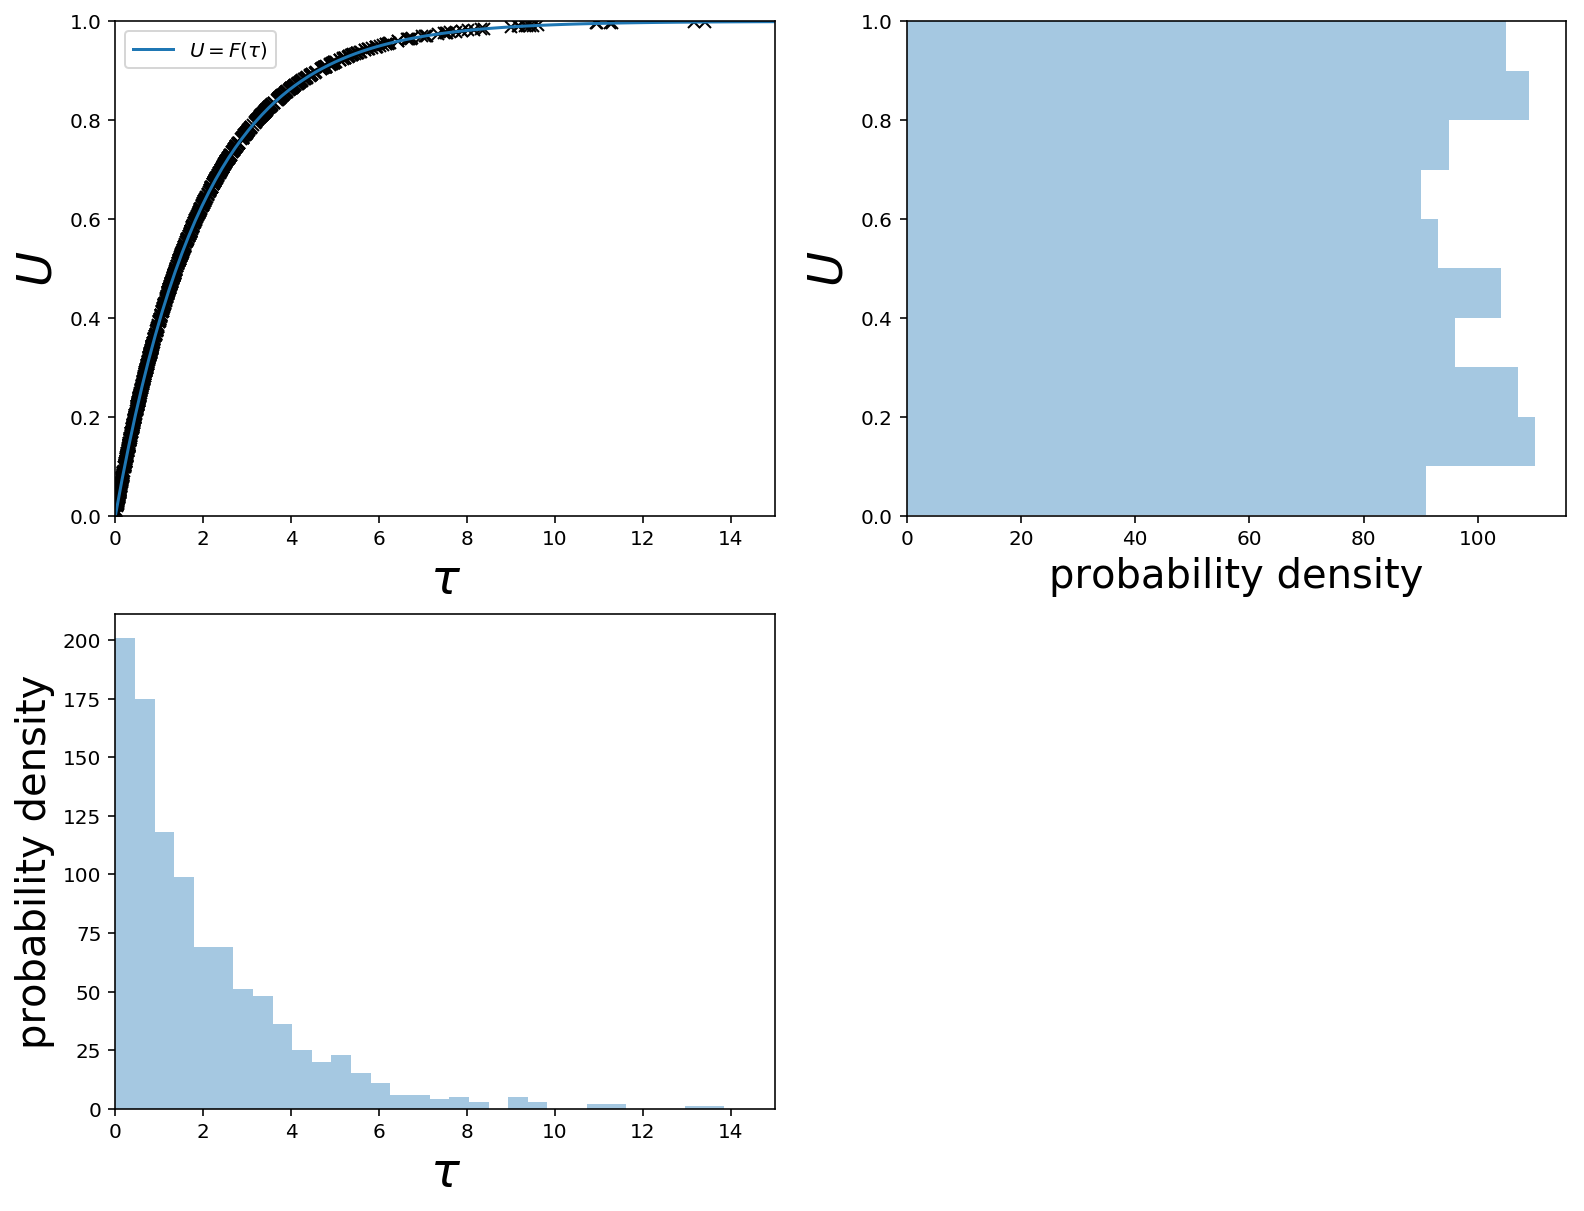

In [11]:
fig = figure(1, [13, 10])
fig.add_subplot(221)
plot(tau, u, 'kx')

t = linspace(0, 15, 100)
P = 1 - exp(-lam*t)
plot(t, P, label=r'$U = F(\tau)$')

ylabel(r'$U$', fontsize=24)
xlabel(r'$\tau$', fontsize=24)

xlim(0, 15)
ylim(0, 1)
legend()


fig.add_subplot(222)
sns.distplot(u, vertical=True, kde=False)

ylim(0, 1)
ylabel(r'$U$', fontsize=24)
xlabel(r'probability density', fontsize=20)


fig.add_subplot(223)
sns.distplot(tau, kde=False)
xlim(0, 15)
ylabel(r'probability density', fontsize=20)
xlabel(r'$\tau$', fontsize=24);


## Sampling from categorical distributions
The above procedure also applies to discrete random variables. Let $0\leq N \leq N_{\rm max}$ be a categorical random variable and let $p(n)$ be its probability distribution. We can generate samples with
\begin{align*}
  U &\sim \text{Uniform}(0, 1) \\
  N &= \min_j\left\{U < \sum_{n=0}^j p(n) \right\}
\end{align*}


In [67]:
def sample_categorical(log_weights, Nsamples):
    ## this function can be vectorized to sample multiple distributions
    unnormalized_weights = exp(log_weights - log_weights.max())
    W_unnormalized = cumsum(unnormalized_weights) ## we will have 
    W = W_unnormalized/W_unnormalized[-1]
    u = rand(Nsamples)
    c = searchsorted(W, u)
    return c

log_weights = tau[:10]
Nsamples = 100

unnormalized_weights = exp(log_weights - log_weights.max())

W_unnormalized = cumsum(unnormalized_weights) ## we will have W_unnormalized[-1] != 1

W = W_unnormalized/W_unnormalized[-1]
u = rand(Nsamples)

c = searchsorted(W, u)



array([5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 5, 6, 5, 6, 5, 6, 6, 5, 2, 8, 6, 6, 5, 5, 5, 5, 5, 5, 6,
       5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 5, 6, 6, 6, 6, 5,
       5, 5, 6, 6, 5, 2, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 7, 5, 6, 5, 6, 5,
       5, 6, 5, 1, 5, 6, 6, 5, 6, 5, 5, 5])

In [27]:
unnormalized_weights[0]

0.01099456265281001

# Distributions can be approximately represented by a collection of samples
Suppose we have $N$ i.i.d samples $x_j \sim f$ from a density $f(x)$. We can approximate the density function with
$$ f(x) \approx \frac{1}{N}\sum_{j=1}^N \delta(x - x_j),$$
where $\delta()$ is the Dirac delta function.

$$ \int_{-\infty}^x \delta(u - x') du = 
\begin{cases}
1, & x > x'\\
0, & \text{otherwise}
\end{cases}
$$

$$
g(y) = \int_{-\infty}^{\infty} g(x)\delta(x - y) dx
$$
Mean or expectation
$$ E[x] = \int_{-\infty}^{\infty} x f(x) dx \approx \int_{-\infty}^{\infty} x \frac{1}{N}\sum_{j=1}^N \delta(x - x_j) dx $$
$$=\frac{1}{N}\sum_{j=1}^N \int_{-\infty}^{\infty} x \delta(x - x_j) dx$$
$$=\frac{1}{N}\sum_{j=1}^N x_j$$
which is the standard empirical sample mean.

# Importance sampling
We might not be able to sample from the distribution we are interested in. We can still approximate the density function if we can sample from another distribution that is compatible.

Suppose we have $N$ i.i.d samples $x_j \sim q$ from a density $q(x)$. We can approximate the density function $f(x)$ with
$$ f(x) \approx \sum_{j=1}^N w_j\delta(x - x_j),$$
where the unnormalized importance weights are given by
$$\hat{w}_j = \frac{f(x_j)}{q(x_j)}$$
and the normalized weights are
$$ w_j = \frac{\hat{w}_j}{\sum_{i=1}^N w_i} $$

# Markov chain examples
Markov chains are defined through a stepping rule (sometimes called a propegator) that tells us how to move the chain forward one step, from $X_{t-1}$ to $X_t$. 

The rule for Markov chains is that the stepping rule can only depend on the most recent previous step. That is,
$$ X_t = g(X_{t-1}).$$

For example, the chain $ X_t = g(X_{t-1}, X_{t-2})$ is not Markovian because the stepping rule depends on $X_{t-1}$ and $X_{t-2}$.

### The usual way to define a Markov chain is by picking a *transition density* $f(x_t| x_{t-1})$

## Simple random walk
$$ x_t \sim \text{Normal}(x_{t-1}, \sigma)$$
with initial condition $x_0$ given.


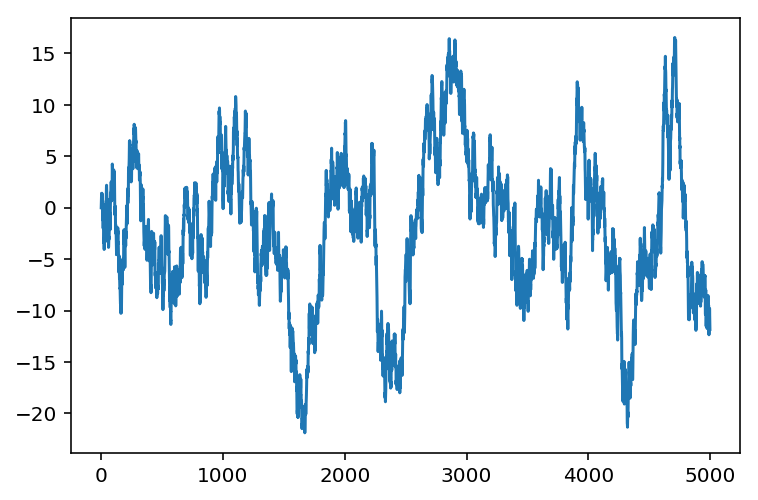

In [12]:
Nsteps = 5000
sigma = 3./4.
x0 = 0.
x = zeros(Nsteps)
x[0] = x0
for t in arange(1, Nsteps):
    x[t] = normal(x[t-1], sigma)

plot(x);

### Probability density function for $X_t$
$$\text{Prob}[X_t \in (a, b)] \approx \int_{a}^{b}p_t(x)dx$$
The density function is $p_t(x)$ and can sometimes be written as the function $p(x, t \mid x_0)$. It satisfies a Chapman Kolmogorov equation.

### Example
Consider
$$X_t \sim \text{Normal}(0, t^2).$$

In [9]:
@interact(t=(.2, 2, .1))
def pfun(t=0.2):
    figure(1, [6, 4])
    x = linspace(-5, 5, 200)
    y = sqrt(1/(2*pi))/t*exp(-x**2/(2.*t))
    plot(x, y)
    ylim(0, 2)

interactive(children=(FloatSlider(value=0.2, description='t', max=2.0, min=0.2), Output()), _dom_classes=('wid…

### We are interested in the distribution of $X_t$ in the limit $t\to \infty$
$$ \lim_{t\to\infty}p_t(x | x_0) = p_{\infty}(x)$$
**Sometime the limit does not exist.**

## Show that the (above) chain does not converge to a stationary distribution

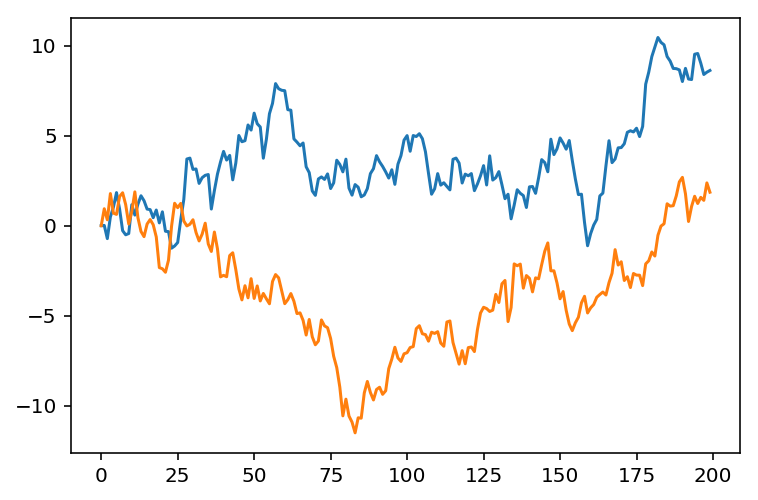

In [23]:
Nsteps = 200
Nchains = 500
sigma = 3./4.
x0 = 0.

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    x[:, t] = normal(x[:, t-1], sigma)
    
plot(x[0, :]); # first chain
plot(x[1, :]); # second chain 

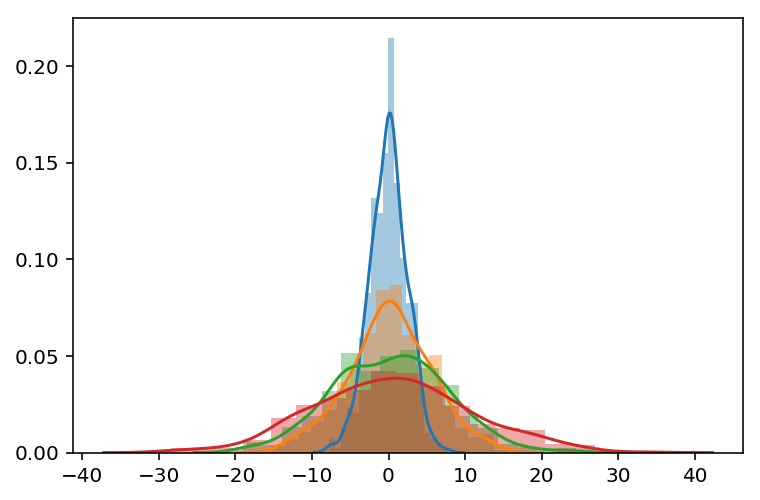

In [25]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100])
sns.distplot(x[:, -1]);

## Simple random walk + periodic boundary conditions targets a uniform distribution

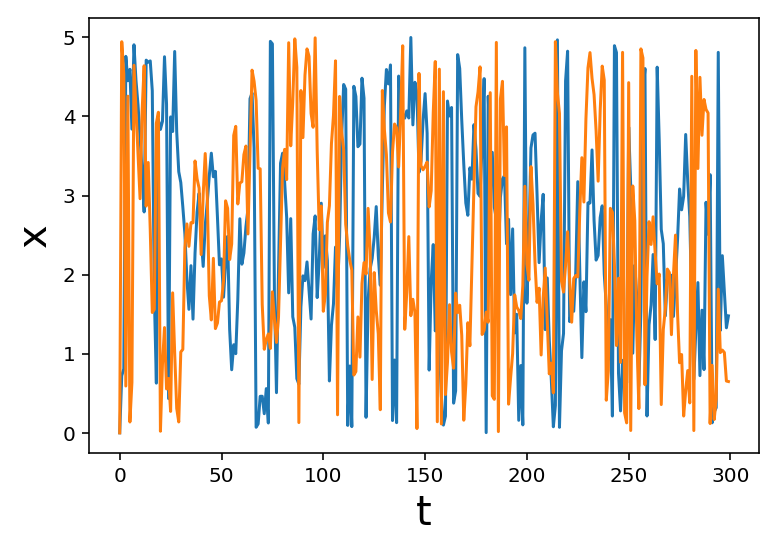

In [37]:
Nsteps = 300
Nchains = 5000
sigma = 3./4.
x0 = 0.

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    xt = normal(x[:, t-1], sigma)
    xt[xt > 5] -= 5
    xt[xt < 0] += 5
    x[:, t] = xt
    
plot(x[0, :]); # first chain
plot(x[1, :]); # second chain 
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

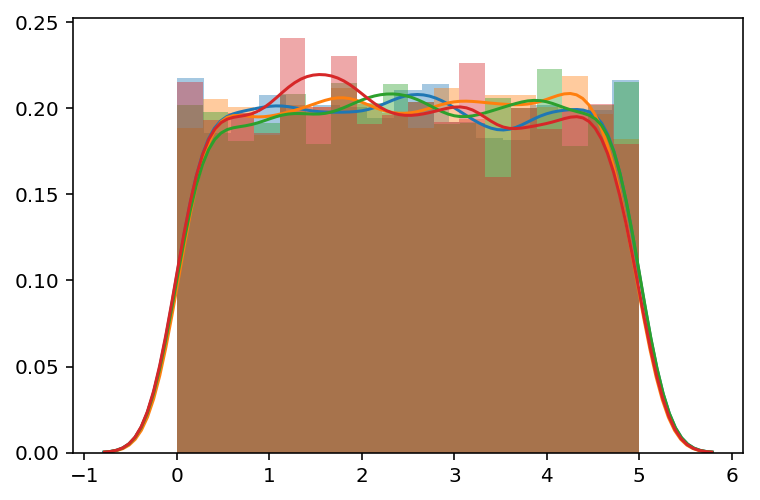

In [39]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100]);
sns.distplot(x[:, 299]);

## An Ornstein-Uhlenbeck chain targets a normal distribution

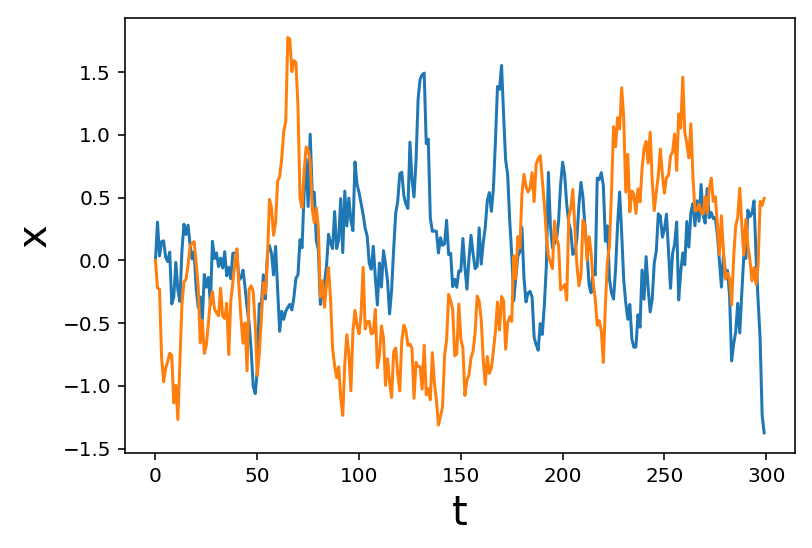

In [40]:
Nsteps = 300
Nchains = 5000
sigma = 3./4.
dt = 0.1



x0 = 0.

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    xt = normal((1 - dt)*x[:, t-1], sqrt(dt)*sigma)
    x[:, t] = xt
    
plot(x[0, :]); # first chain
plot(x[1, :]); # second chain 
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

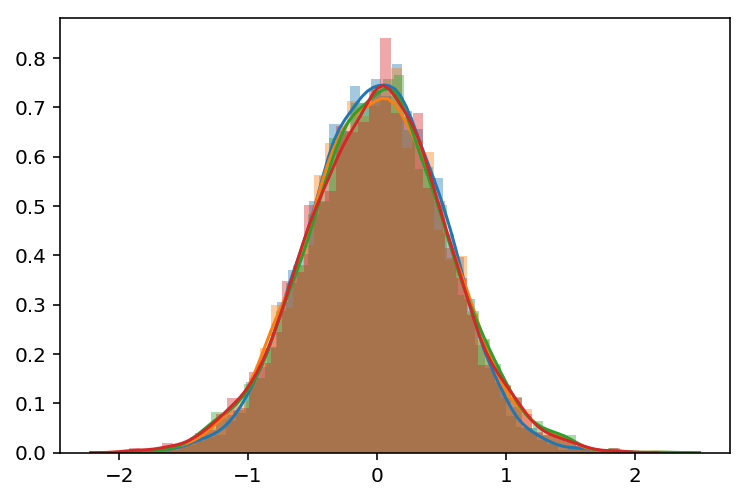

In [42]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100]);
sns.distplot(x[:, 299]);

# Metropolis - Hastings
Unfortunately, in most cases the "direct" sampling approach described above does not work. Sampling the posterior distribution is complicated by two factors.
  1. The cumulative distribution function cannot be inverted analytically
  2. We typically only have access to the *un-normalized* posterior distribution

## Problem: generate samples from an un-normalized distribution, possibly in high dimensions
We typically start with the logarithm of the so called *target* distribution. Suppose the true normalized posterior is $\Pi(\theta | D)$, where $\theta$ is one or more parameters and $D$ is the data. We will typically start with something like
$$ L(\theta | D) = \log(\alpha\Pi(\theta | D)), $$
where $\alpha$ is a constant that we do not know. Our goal is generate samples from the posterior give a function $L(\theta | D)$.

## Algorithm:
Suppose that the target density function is $p(x)$ and that we have the unnormalized log density $L(x) = \log(\alpha p(x))$. 

### Markov chain:
Construct a Markov chain $x_t$, with transition density $f(x_t | x_{t-1})$ and a stationary density $\lim_{t_0 \to -\infty} p(x_t | x_{t_0}) = p_{\infty}(x_t) = p(x)$ that is equal to our target density. A sufficient but not necessary condition for this is to use a Markov chain that satisfies *detailed balance*
$$f(x' | x)p_{\infty}(x) = f(x | x')p_{\infty}(x').$$
We also need for the process to be *ergodic*, which simply means that every state is sufficiently accessible for any valid initial condition.

### Constructing the chain
Assuming detailed balance (see above), we have
$$\frac{f(x' | x)}{f(x | x')} = \frac{p_{\infty}(x')}{p_{\infty}(x)}.$$
We split the chain into two steps:
  1. a proposal step with distribution $q(x_t | x_{t-1})$
  2. an acceptance step with acceptance probability 
  $$p_{MH}(x_t, x_{t-1}) = \min\left\{1, \frac{p(x_{t})q(x_{t-1} | x_{t})}{p(x_{t-1})q(x_{t} | x_{t-1})} \right\}$$
We then set our transition probability to
$$ f(x_t | x_{t-1}) =  q(x_t | x_{t-1})p_{MH}(x_t, x_{t-1}) + \delta(x_t - x_{t-1})
\int_{-\infty}^{\infty}q(x' | x_{t-1})(1 - p_{MH}(x', x_{t-1}))dx'
.$$


### Algorithm steps:
Given $x_0$. At step $t$:
  1. sample $\hat{x} \sim q(\cdot | x_{t-1})$
  2. calculate acceptance probability 
  $$p_{MH} = \min\left\{1, \frac{p(\hat{x})q(x_{t-1} \mid \hat{x})}{p(x_{t-1})q(\hat{x} \mid x_{t-1})} \right\}$$
  3. compute $u \sim \text{Uniform}(0, 1)$
  4. compute 
  $$\chi = \begin{cases}
  1, & u < p_{MH} \\
  0, & \text{otherwise}
  \end{cases}
  $$
  5. Set $x_{t} = \hat{x}\chi + x_{t-1}(1 - \chi)$

## Disadvantages

  1. $x_{t+s}$ and $x_t$ are correlated for small $s$. We cannot treat all the steps of the chain as independent samples of the target distribution
  2. The samples converge to samples of the target distribution as the number of steps $t\to\infty$. In practice we need $t$ large enough, and sometimes, this can be too large for practical purposes. 
  3. The choice of initial condition $x_0$ leads to transient behavior in the chain, and it is often necessary to run a "burn in" chain for some number of steps to produce a better initial condition.

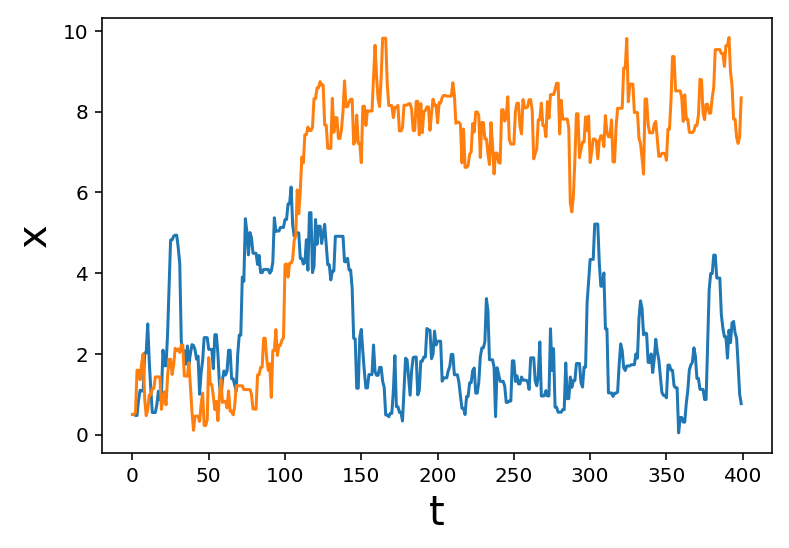

In [67]:
def target_density(x):
    return (x > 0)*exp(-0.5*x)

def target_density(x, x1=-2, x2=2):
    return exp(-(x - x1)**2) + exp(-(x - x2)**2)

def target_density(x):
    return (x > 0)*(x < 10)*(0.1 + sin(x)**2)

def proposal_density(x, y):
    return stats.norm.pdf(x, y, sigma)

Nsteps = 400
Nchains = 5000
sigma = 3./4.



x0 = 0.5

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    xold = x[:, t-1]
    xhat = normal(xold, sigma)
    pMH = (target_density(xhat)*proposal_density(xold, xhat)/
          (target_density(xold)*proposal_density(xhat, xold)))
    pMH = minimum(1, pMH)
    u = rand(Nchains)
    chi = u < pMH
    x[:, t] = xhat*chi + xold*(1 - chi)
    
plot(x[0, :]); # first chain
plot(x[1, :]); # second chain 
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

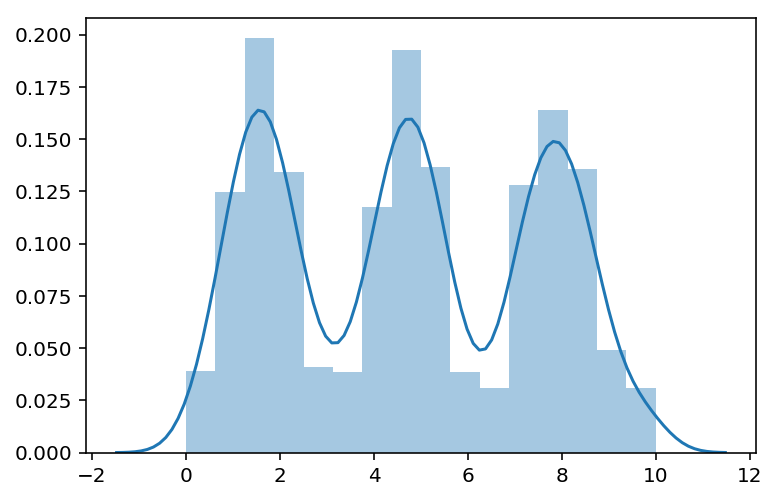

In [68]:
# sns.distplot(x[:, 10])
# sns.distplot(x[:, 50])
# sns.distplot(x[:, 100]);
sns.distplot(x[:, 299]);
xplot = linspace(0.001, 15, 200)
# plot(xplot, 0.5*target_density(xplot), 'k');

# Gibbs sampling
While this is not obvious, the Gibbs sampler is a special case of the Metropolis-Hastings algorithm, where the acceptance probability is always $A = 1$. Hence, acceptance or rejection of a proposal is not a necessary component of a coding up a Gibbs sampling algorithm.

Suppose we want to sample from a high dimensional joint distribution
$$ p(x_1, x_2, \ldots, x_n)$$
The strategy is to construct a Markov chain by sampling each coordinate sequentially. That is, for $j=1,2,\ldots, n$ we set the jth component of ${\bf x}^t$ to
$$ x_j^t \sim p(\cdot | x_1^t, x_2^t, \ldots, x_{j-1}^t, x_{j+1}^{t-1}, \ldots, x_n^{t-1}) \propto p(x_1^t, x_2^t, \ldots, x_{j-1}^t, \cdot , x_{j+1}^{t-1}, \ldots, x_n^{t-1})$$
One can show that this generates a Markov chain with the desired target distribution.